# Import Dependencies

In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

%matplotlib inline

# Generate dataset

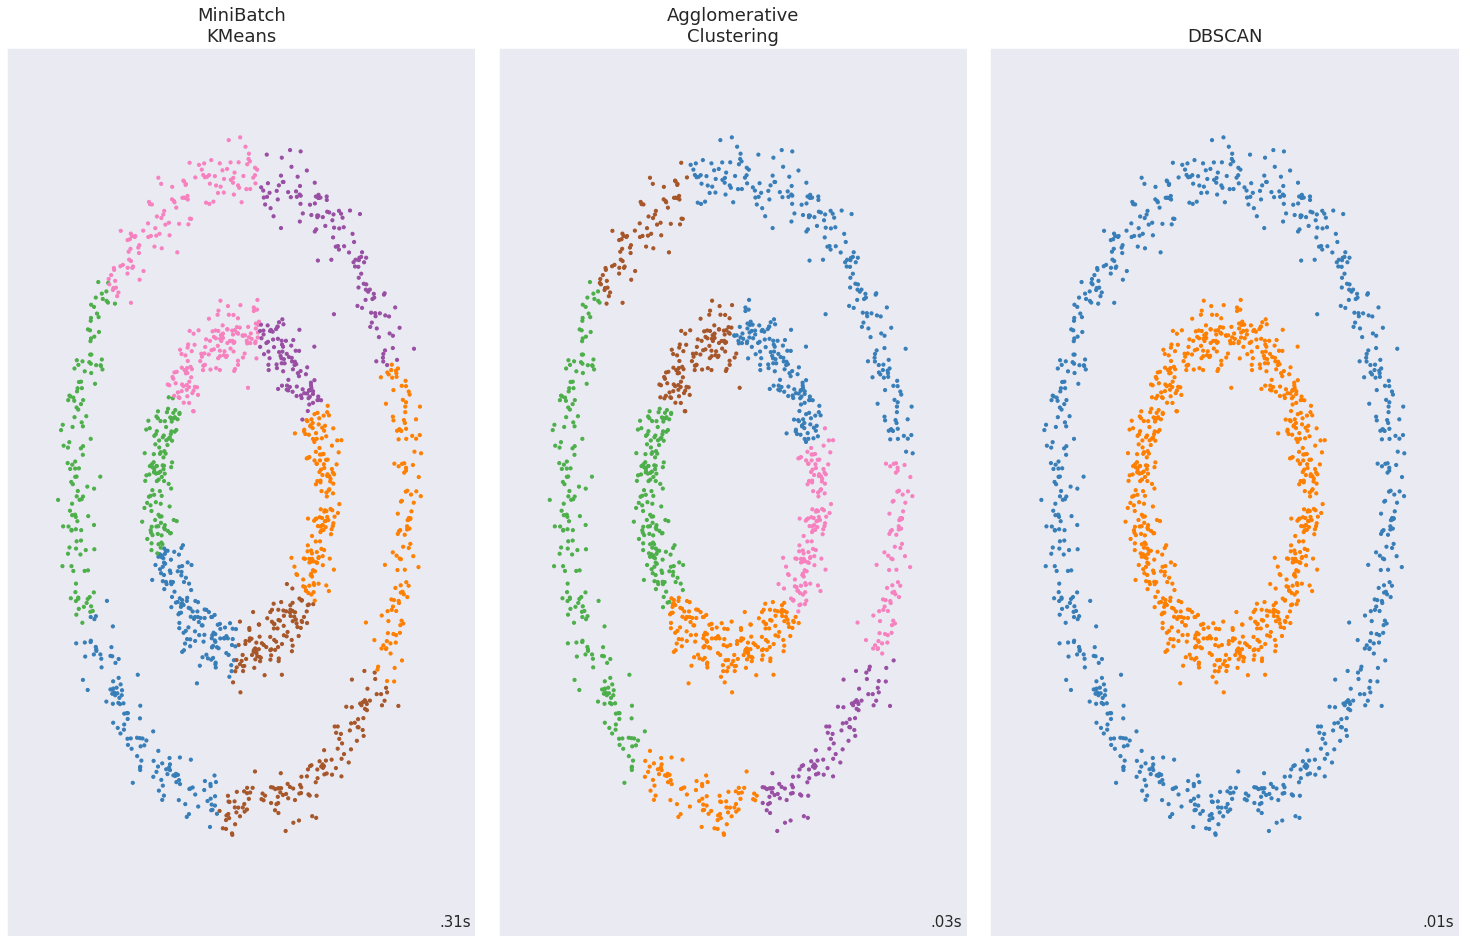

In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 2,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 6,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)


    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    average_linkage = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means), # Partitive
        ("Agglomerative\nClustering", average_linkage), # Hierarchical
        ("DBSCAN", dbscan), # Partitive
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

Links to the scikit-learn page:
- https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods
- https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

## MiniBatch k-Means

This algorithm is partitive.

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. This algorithm combines data into a cluster, where it tries to separate the data in k groups with the same variance. It tries to minimize the so-called inertia.

The algorithm initializes k random points and moves it step by step to the middle of the cluster so that they get centroids. After every step the points get assigned to the nearest cluster. The algorithm stops if the points do not change anymore.

Various executions of the algorithm can lead to different results, because the points get randomly initialized.

I have chosen this algorithm because it is pretty simple to explain and executes very fast. I can choose how many clusters i want to have.

## Agglomerative Clustering - Ward

This algorithm is hierarchical.

The agglomerative clustering algorithm performs a hierarchical clustering using a bottom-up approach. Each point starts in its own cluster and clusters are merged together in each step. We can specify the linkage criteria for the algorithm, which specifies how the results are merged.

I chose Ward linkage:
- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach. With this I can better compare k-means and this algorithm.

I have chosen this algorithm, because of its similarity with the k-means algorithm. And its one of the hierarchical algorithms from the sklearn-library.



## DBSCAN

This algorithm is partitive.

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.

There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

In comparison to k-means we don't have to specify the number of clusters before.
DBSCAN is deterministic, so we always get the same result. Therefore, I choose this algorithm in contrast to k-means.

# Comparison

![Comparison](./img/toy-dataset.png)

I choose a large amount of clusters (6) here for the three algorithms. For DBSCAN we do not have to specify the amount of clusters. The algorithm finds two clusters.

When we look at the agglomerative clustering algorithm, we see that the clusters look quite the same as k-means. Only one cluster is on only on the outside of the data and not on the inside. But overall the two graphs look quite the same. With the clusters have points on the inside and outside of the ring.

k-Means produces as many cluster i specify, the clusters that k-Means finds are convex, which can be seen in the image. The clusters are all the same size and look the same. This dataset is especially well suited for k-means as it is easy to produce convex clusters.


Here we see a clustering with two clusters. k-means splits the data exactly in half. The clusters span across the inner and outer data.

Whereas, agglomerative clustering and DBSCAN separate the data into an inner and outer cluster.

![Comparison](./img/toy-dataset-c-2.png)
